In [12]:
#install and download needed packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
import scipy
from sklearn.ensemble import RandomForestRegressor, VotingRegressor, StackingRegressor,BaggingRegressor,GradientBoostingRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict,KFold
from sklearn.metrics import mean_squared_error,accuracy_score, mean_absolute_error, mean_absolute_percentage_error
from sklearn.decomposition import PCA
import statsmodels.api as sm
warnings.filterwarnings('ignore')

In [13]:
data= pd.read_csv('Bankofamerica.csv')

In [14]:
data.shape 

(7551, 7)

In [15]:
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1994-02-28,12.15625,12.28125,12.12500,12.21875,5.562675,2134000
1,1994-03-01,12.15625,12.18750,12.03125,12.18750,5.548449,1909200
2,1994-03-02,12.03125,12.03125,11.78125,11.96875,5.448860,5032000
3,1994-03-03,11.93750,11.93750,11.65625,11.78125,5.363500,2323200
4,1994-03-04,11.78125,12.00000,11.75000,11.93750,5.434634,2524800


In [16]:
data.index 

RangeIndex(start=0, stop=7551, step=1)

In [17]:
data=data.rename(columns={'Date':'date','Open':'open','High':'high','Low':'low','Close':'close','Volume':'volume'})

In [18]:
data=data.drop(columns=['Adj Close'],axis=1)

In [19]:
data['date']=pd.to_datetime(data['date'])

In [20]:
data.set_index('date', inplace=True)

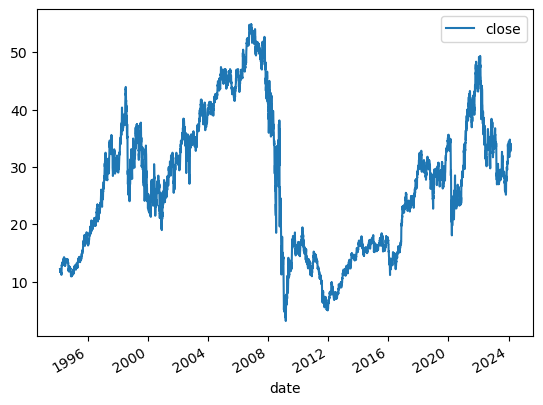

In [21]:
data.plot.line(y='close', use_index=True)
plt.savefig('Bankofamerica.png');

In [22]:
data.describe()

,open,high,low,close,volume
count,7551.000000,7551.000000,7551.000000,7551.000000,7.551000e+03
mean,27.165799,27.477625,26.845990,27.161043,6.543266e+07
std,12.087993,12.167950,12.012236,12.092193,9.280876e+07
min,3.220000,3.510000,2.530000,3.140000,7.004000e+05
25%,16.030001,16.200001,15.800000,16.015000,9.533500e+06
50%,27.843750,28.174999,27.420000,27.790001,3.687110e+07
75%,35.400002,35.777501,34.924999,35.349998,8.313725e+07
max,55.040001,55.080002,54.820000,54.900002,1.226791e+09


In [23]:
data['Tomorrow']=data['close'].shift(-1)

In [24]:
data.head() 

,open,high,low,close,volume,Tomorrow
date,,,,,,
1994-02-28,12.15625,12.28125,12.12500,12.21875,2134000,12.18750
1994-03-01,12.15625,12.18750,12.03125,12.18750,1909200,11.96875
1994-03-02,12.03125,12.03125,11.78125,11.96875,5032000,11.78125
1994-03-03,11.93750,11.93750,11.65625,11.78125,2323200,11.93750
1994-03-04,11.78125,12.00000,11.75000,11.93750,2524800,11.65625


In [25]:
data['previousday']=data['close'].shift(1)

In [26]:
data.head()

,open,high,low,close,volume,Tomorrow,previousday
date,,,,,,,
1994-02-28,12.15625,12.28125,12.12500,12.21875,2134000,12.18750,NaN
1994-03-01,12.15625,12.18750,12.03125,12.18750,1909200,11.96875,12.21875
1994-03-02,12.03125,12.03125,11.78125,11.96875,5032000,11.78125,12.18750
1994-03-03,11.93750,11.93750,11.65625,11.78125,2323200,11.93750,11.96875
1994-03-04,11.78125,12.00000,11.75000,11.93750,2524800,11.65625,11.78125


In [27]:
train = data.iloc[:-1000]
test = data.iloc[-1000:]

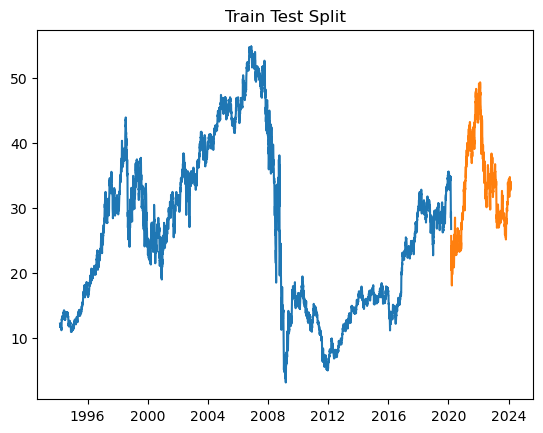

In [28]:
import matplotlib.pyplot as plt 
plt.plot(train['close'], label='train')
plt.plot(test['close'], label='test')
plt.title('Train Test Split');

In [29]:
# Utility function
def evaluate_model(model, x, y):
    """
    Utility function to print the model performance, (MAE and MAPE)
    model: Fitted model
    x:  features dataset
    y:  target values
    """
    predicted = model.predict(x) #get predictions
    mae = mean_absolute_error(y_true=y, y_pred=predicted)
    abs_errors= np.abs(np.array(predicted) - np.array(y))
    min_abs_errors= np.min(abs_errors)
    max_abs_errors= np.max(abs_errors)
    med_abs_errors= np.median(abs_errors)
    mape = mean_absolute_percentage_error(y, predicted)

    print('MAE: {:.2f}'.format(mae))
    print('MAPE: {:.2f}'.format(mape))
    print('minae: {:.2f}'.format(min_abs_errors))
    print('maxae: {:.2f}'.format(max_abs_errors))
    print('medae: {:.2f}'.format(med_abs_errors))
    print()

In [30]:
#predictors_1 = ["close", "volume", "open", "high", "low"]
predictors_2 = ["volume", "open", "high", "low"]

In [31]:
# creating a dictionary of Regressors to be experimented on.
models_dict = {
          'RF Regressor':RandomForestRegressor(random_state=0),
          'xgboost': XGBRegressor(),'Gradient Boost': GradientBoostingRegressor(random_state=0),
    'Catboostregressor':CatBoostRegressor(iterations=100, early_stopping_rounds=50)
         }

#looping through all the regressors, fitting and evaluating them on  test data respectively
for key, model in models_dict.items():
    model.fit(train[predictors_2], train['close'])
    print(f'Performance of "{key}" on Validation and Test set:')
    print('=='*28)
    print ( 'Test set:')
    print("**"*8)
    evaluate_model(model,test[predictors_2], test['close'])





Performance of "RF Regressor" on Validation and Test set:
Test set:
****************
MAE: 0.21
MAPE: 0.01
minae: 0.00
maxae: 1.50
medae: 0.16

Performance of "xgboost" on Validation and Test set:
Test set:
****************
MAE: 0.23
MAPE: 0.01
minae: 0.00
maxae: 1.71
medae: 0.17

Performance of "Gradient Boost" on Validation and Test set:
Test set:
****************
MAE: 0.25
MAPE: 0.01
minae: 0.00
maxae: 1.23
medae: 0.20

Learning rate set to 0.358225
0:	learn: 8.2809362	total: 143ms	remaining: 14.1s
1:	learn: 5.5245941	total: 157ms	remaining: 7.71s
2:	learn: 3.7593285	total: 164ms	remaining: 5.3s
3:	learn: 2.5914994	total: 179ms	remaining: 4.3s
4:	learn: 1.8098337	total: 188ms	remaining: 3.56s
5:	learn: 1.3219678	total: 192ms	remaining: 3s
6:	learn: 1.0233260	total: 195ms	remaining: 2.59s
7:	learn: 0.8611138	total: 200ms	remaining: 2.3s
8:	learn: 0.7772309	total: 206ms	remaining: 2.09s
9:	learn: 0.7222197	total: 211ms	remaining: 1.9s
10:	learn: 0.6893694	total: 215ms	remaining: 1.74s


#### Retrain the best Model(Extreme Gradient Boosting)

In [32]:
model= GradientBoostingRegressor()
model.fit(train[predictors_2], train['close'])
pred= model.predict(test[predictors_2])

In [33]:

pred= pd.Series(pred, index=test.index)
combined_2= pd.concat([test['close'], pred],axis=1)

In [34]:
#combined_1.plot();
combined_2

,close,0
date,,
2020-03-06,25.709999,25.435783
2020-03-09,21.930000,22.625278
2020-03-10,23.610001,22.778592
2020-03-11,22.670000,22.823706
2020-03-12,20.510000,21.417720
...,...,...
2024-02-20,33.959999,33.619339
2024-02-21,33.700001,33.573986
2024-02-22,33.610001,33.573986


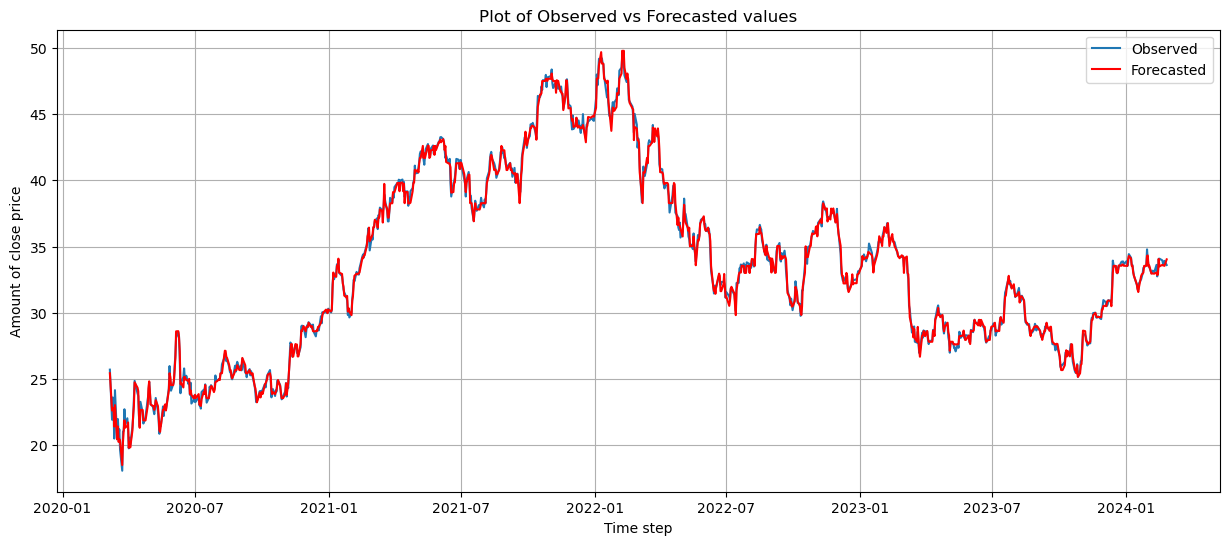

In [35]:
# Plot the test predictions and true values
plt.figure(figsize=(15,6))
plt.plot(combined_2['close'], label='Observed')
plt.plot(combined_2[0], color='r', label='Forecasted')
plt.title('Plot of Observed vs Forecasted values')
plt.ylabel('Amount of close price')
plt.xlabel('Time step')
plt.legend()
plt.grid()
plt.savefig('forcast.png')
plt.show()

In [36]:
#add additional predictors to the model
#calculate the mean close price in certain days and  find the ratio between today's closing price and that of the periods
horizons = [2,5,60,250,1000]
new_predictors = []

for horizon in horizons:
    rolling_averages = data.rolling(horizon).mean()
    
    ratio_column = f"Close_Ratio_{horizon}"
    data[ratio_column] = data["close"] / rolling_averages["close"]
    
    trend_column = f"Trend_{horizon}"
    data[trend_column] = data.shift(1).rolling(horizon).sum()["close"]
    
    
    
    new_predictors+= [ratio_column, trend_column]

In [37]:
data['mom'] = data['close'].pct_change(12) # 12 month change

In [38]:
#Create the RSI indicator
#data['rsi' + str(n)] = talib.RSI(data['close'].values, timeperiod=horizon)
def computeRSI (data, time_window):
    diff = data.diff(1).dropna()        # diff in one field(one day)

    #this preservers dimensions off diff values
    up_chg = 0 * diff
    down_chg = 0 * diff
    
    # up change is equal to the positive difference, otherwise equal to zero
    up_chg[diff > 0] = diff[ diff>0 ]
    
    # down change is equal to negative deifference, otherwise equal to zero
    down_chg[diff < 0] = diff[ diff < 0 ]
    
    
    # we set com=time_window-1 so we get decay alpha=1/time_window
    up_chg_avg   = up_chg.ewm(com=time_window-1 , min_periods=time_window).mean()
    down_chg_avg = down_chg.ewm(com=time_window-1 , min_periods=time_window).mean()
    
    rs = abs(up_chg_avg/down_chg_avg)
    rsi = 100 - 100/(1+rs)
    return rsi

In [39]:
data['RSI']= computeRSI(data['close'], 14)

In [40]:
data.head()

,open,high,low,close,volume,Tomorrow,previousday,Close_Ratio_2,Trend_2,Close_Ratio_5,Trend_5,Close_Ratio_60,Trend_60,Close_Ratio_250,Trend_250,Close_Ratio_1000,Trend_1000,mom,RSI
date,,,,,,,,,,,,,,,,,,,
1994-02-28,12.15625,12.28125,12.12500,12.21875,2134000,12.18750,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1994-03-01,12.15625,12.18750,12.03125,12.18750,1909200,11.96875,12.21875,0.998720,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1994-03-02,12.03125,12.03125,11.78125,11.96875,5032000,11.78125,12.18750,0.990944,24.40625,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1994-03-03,11.93750,11.93750,11.65625,11.78125,2323200,11.93750,11.96875,0.992105,24.15625,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1994-03-04,11.78125,12.00000,11.75000,11.93750,2524800,11.65625,11.78125,1.006588,23.75000,0.99324,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [41]:
data.shape 

(7551, 19)

In [42]:
new_data=data[new_predictors]
new_data['close']=data['close']
new_data['MOM']=data['mom']
new_data.head()

,Close_Ratio_2,Trend_2,Close_Ratio_5,Trend_5,Close_Ratio_60,Trend_60,Close_Ratio_250,Trend_250,Close_Ratio_1000,Trend_1000,close,MOM
date,,,,,,,,,,,,
1994-02-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.21875,NaN
1994-03-01,0.998720,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.18750,NaN
1994-03-02,0.990944,24.40625,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.96875,NaN
1994-03-03,0.992105,24.15625,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.78125,NaN
1994-03-04,1.006588,23.75000,0.99324,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.93750,NaN


In [43]:
new_data['SMA_3'] = new_data.iloc[:,10].rolling(window=3).mean()
new_data['SMA_4'] = new_data.iloc[:,10].rolling(window=4).mean()

In [44]:
new_data['CMA_4'] = new_data['close'].expanding(min_periods=4).mean()

In [45]:
new_data['EMA'] = new_data.iloc[:,10].ewm(span=40,adjust=False).mean()

In [46]:
new_data=new_data.dropna()
new_data.shape 

(6551, 16)

In [47]:
new_data.head()

,Close_Ratio_2,Trend_2,Close_Ratio_5,Trend_5,Close_Ratio_60,Trend_60,Close_Ratio_250,Trend_250,Close_Ratio_1000,Trend_1000,close,MOM,SMA_3,SMA_4,CMA_4,EMA
date,,,,,,,,,,,,,,,,
1998-02-12,1.000960,64.71875,1.006368,161.12500,1.062186,1838.539063,1.051520,7746.539063,1.609799,20226.71875,32.59375,0.064286,32.437500,32.382812,20.239073,30.943153
1998-02-13,0.993243,65.12500,0.994395,161.93750,1.047075,1841.132813,1.037197,7749.195313,1.586626,20247.09375,32.15625,0.064116,32.427083,32.367188,20.250967,31.002328
1998-02-17,1.002424,64.75000,0.998648,161.68750,1.050915,1842.632813,1.042010,7750.757813,1.592737,20267.06250,32.31250,0.061602,32.354167,32.398438,20.262992,31.066239
1998-02-18,1.000966,64.46875,0.999421,161.78125,1.051843,1844.820313,1.043765,7752.445313,1.594199,20287.40625,32.37500,0.081420,32.281250,32.359375,20.275056,31.130081
1998-02-19,0.997581,64.68750,0.996520,161.96875,1.045917,1846.757813,1.038438,7754.382813,1.584922,20308.00000,32.21875,0.048830,32.302083,32.265625,20.286940,31.183187


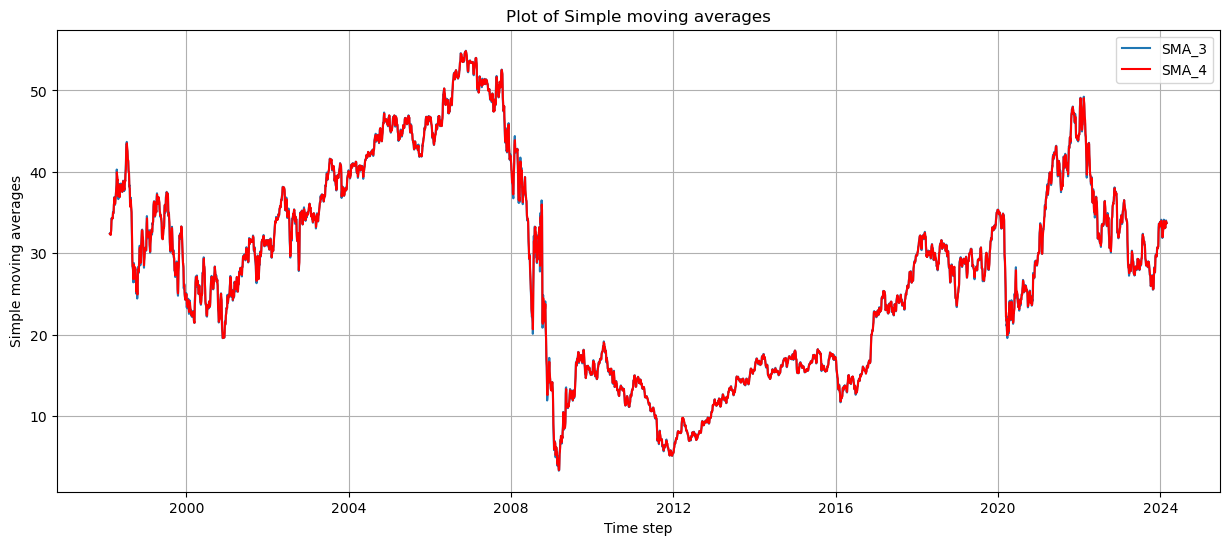

In [48]:
# Plot the test predictions and true values
plt.figure(figsize=(15,6))
plt.plot(new_data['SMA_3'], label='SMA_3')
plt.plot(new_data['SMA_4'], color='r', label='SMA_4')
plt.title('Plot of Simple moving averages')
plt.ylabel('Simple moving averages')
plt.xlabel('Time step')
plt.legend()
plt.grid()
plt.savefig('forcast.png')
plt.show()

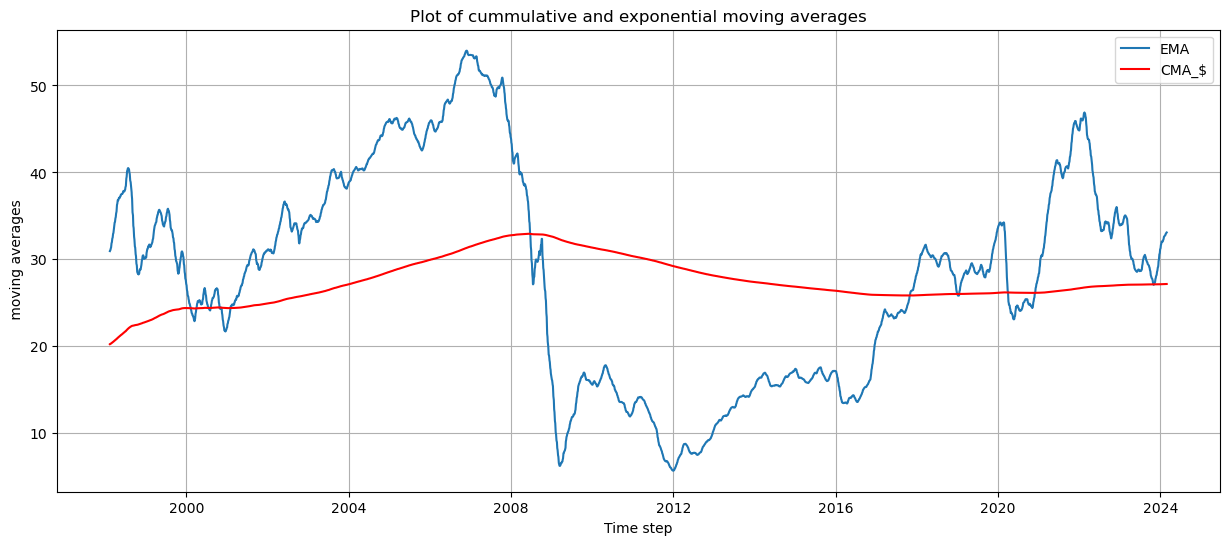

In [49]:
# Plot the test predictions and true values
plt.figure(figsize=(15,6))
plt.plot(new_data['EMA'], label='EMA')
plt.plot(new_data['CMA_4'], color='r', label='CMA_$')
plt.title('Plot of cummulative and exponential moving averages')
plt.ylabel(' moving averages')
plt.xlabel('Time step')
plt.legend()
plt.grid()
plt.savefig('forcast.png')
plt.show()

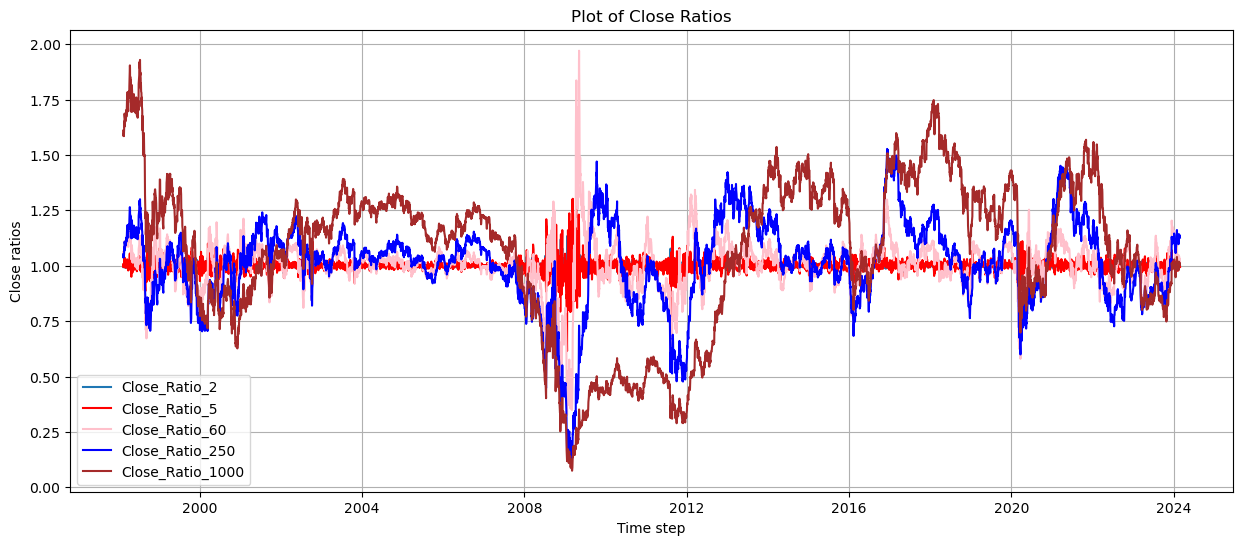

In [50]:
# Plot the test predictions and true values
plt.figure(figsize=(15,6))
plt.plot(new_data['Close_Ratio_2'], label='Close_Ratio_2')
plt.plot(new_data['Close_Ratio_5'], color='r', label='Close_Ratio_5')
plt.plot(new_data['Close_Ratio_60'], color='pink', label='Close_Ratio_60')
plt.plot(new_data['Close_Ratio_250'], color='b', label='Close_Ratio_250')
plt.plot(new_data['Close_Ratio_1000'], color='brown', label='Close_Ratio_1000')
#plt.plot(new_data['close'], color='g', label='Close_Ratio_2')
plt.title('Plot of Close Ratios')
plt.ylabel('Close ratios')
plt.xlabel('Time step')
plt.legend()
plt.grid()
plt.savefig('forcast.png')
plt.show()

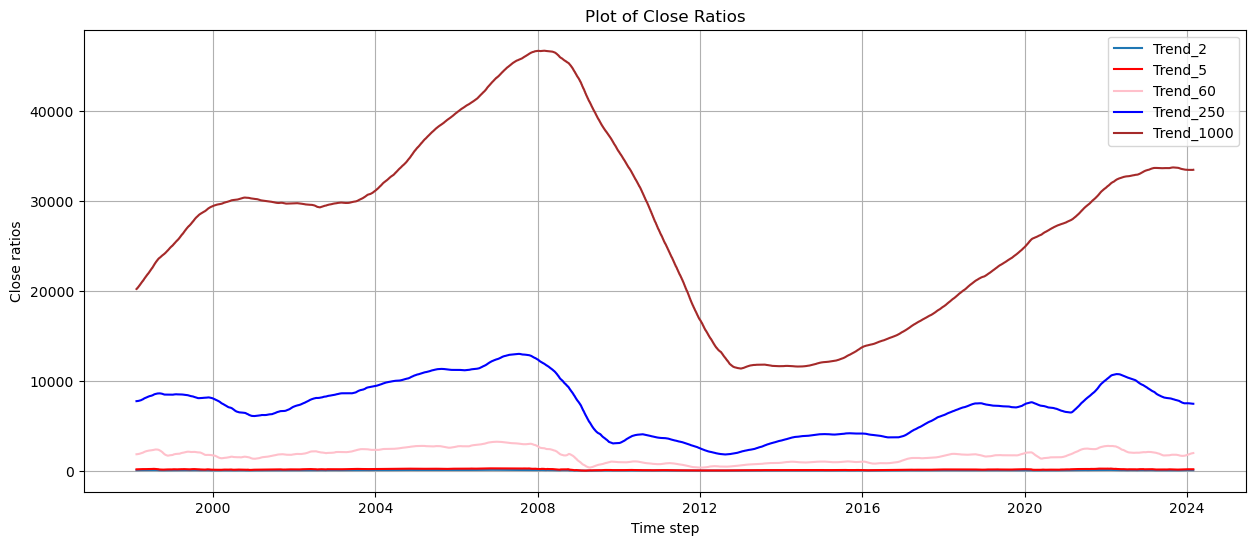

In [51]:
# Plot the test predictions and true values
plt.figure(figsize=(15,6))
plt.plot(new_data['Trend_2'], label='Trend_2')
plt.plot(new_data['Trend_5'], color='r', label='Trend_5')
plt.plot(new_data['Trend_60'], color='pink', label='Trend_60')
plt.plot(new_data['Trend_250'], color='b', label='Trend_250')
plt.plot(new_data['Trend_1000'], color='brown', label='Trend_1000')
#plt.plot(new_data['close'], color='g', label='Close_Ratio_2')
plt.title('Plot of Close Ratios')
plt.ylabel('Close ratios')
plt.xlabel('Time step')
plt.legend()
plt.grid()
plt.savefig('forcast.png')
plt.show()

In [52]:
new_data['RSI']=data['RSI']
new_data['previousday']=data['previousday']

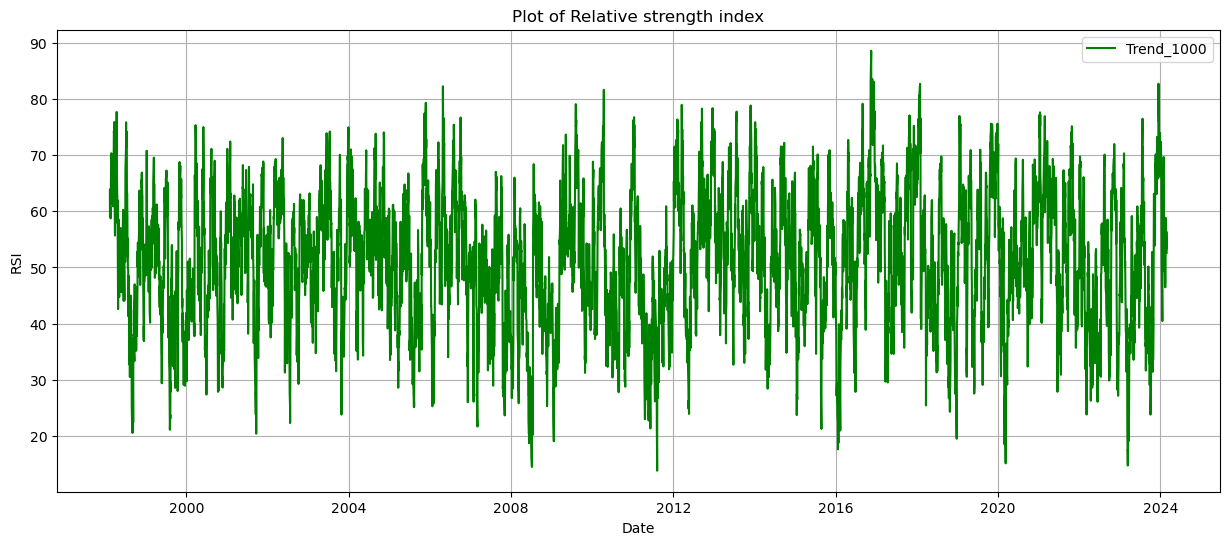

In [53]:
# Plot the test predictions and true values
plt.figure(figsize=(15,6))
plt.plot(new_data['RSI'], color='g', label='Trend_1000')
#plt.plot(new_data['close'], color='g', label='Close_Ratio_2')
plt.title('Plot of Relative strength index')
plt.ylabel('RSI')
plt.xlabel('Date')
plt.legend()
plt.grid()
plt.savefig('forcast.png')
plt.show()

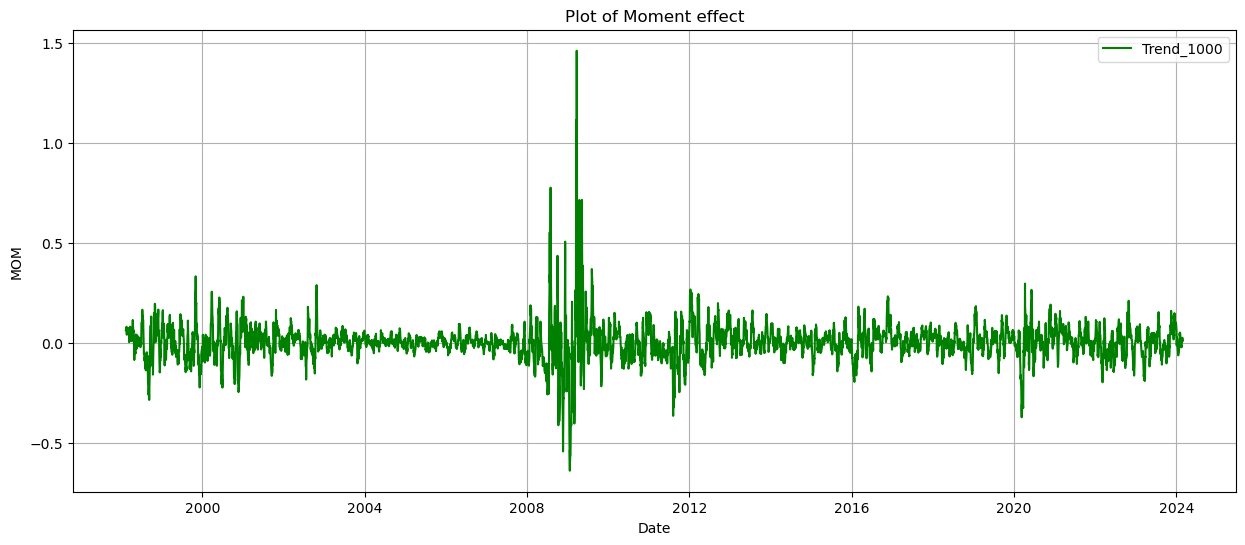

In [54]:
# Plot the test predictions and true values
plt.figure(figsize=(15,6))
plt.plot(new_data['MOM'], color='g', label='Trend_1000')
#plt.plot(new_data['close'], color='g', label='Close_Ratio_2')
plt.title('Plot of Moment effect')
plt.ylabel('MOM')
plt.xlabel('Date')
plt.legend()
plt.grid()
plt.savefig('forcast.png')
plt.show()

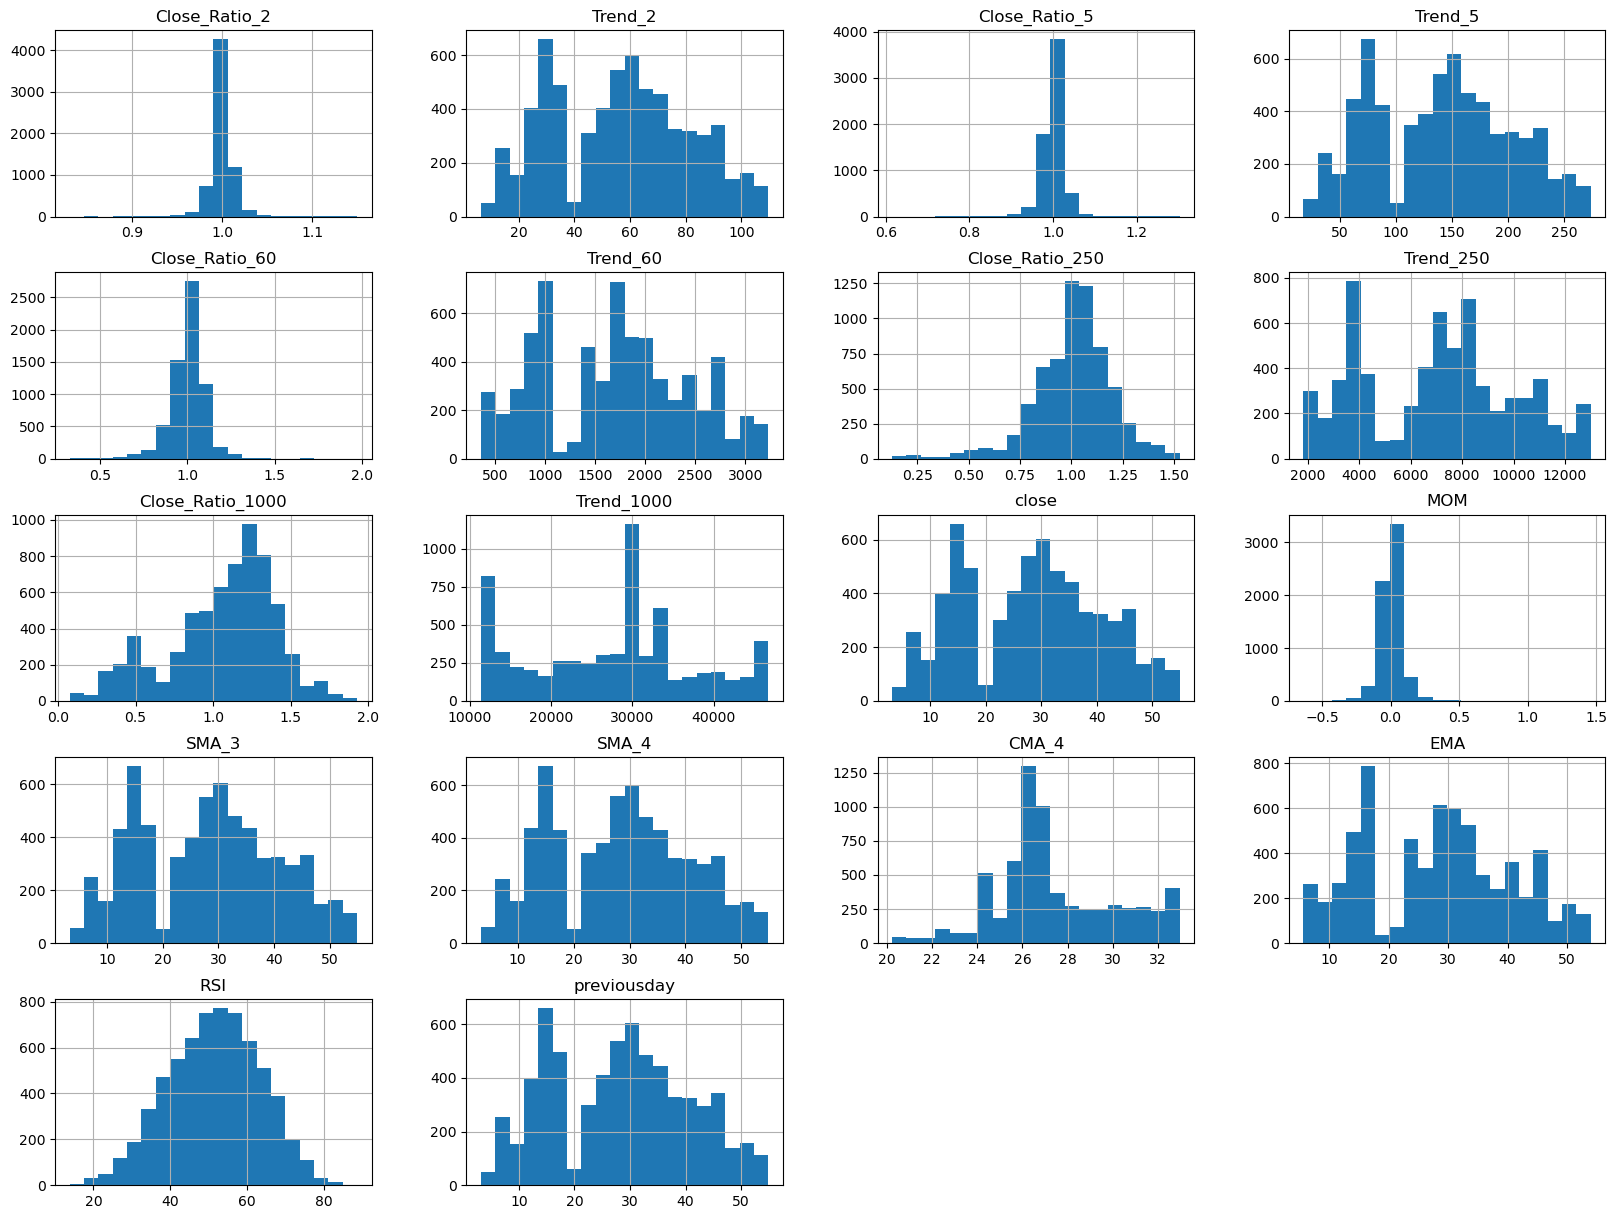

In [55]:
columns= ['Close_Ratio_2', 'Trend_2', 'Close_Ratio_5', 'Trend_5',
       'Close_Ratio_60', 'Trend_60', 'Close_Ratio_250', 'Trend_250',
       'Close_Ratio_1000', 'Trend_1000', 'close', 'MOM', 'SMA_3', 'SMA_4',
       'CMA_4', 'EMA', 'RSI', 'previousday']


new_data[columns].hist( bins=20, figsize=(20,15))
plt.savefig('charts_1.png');

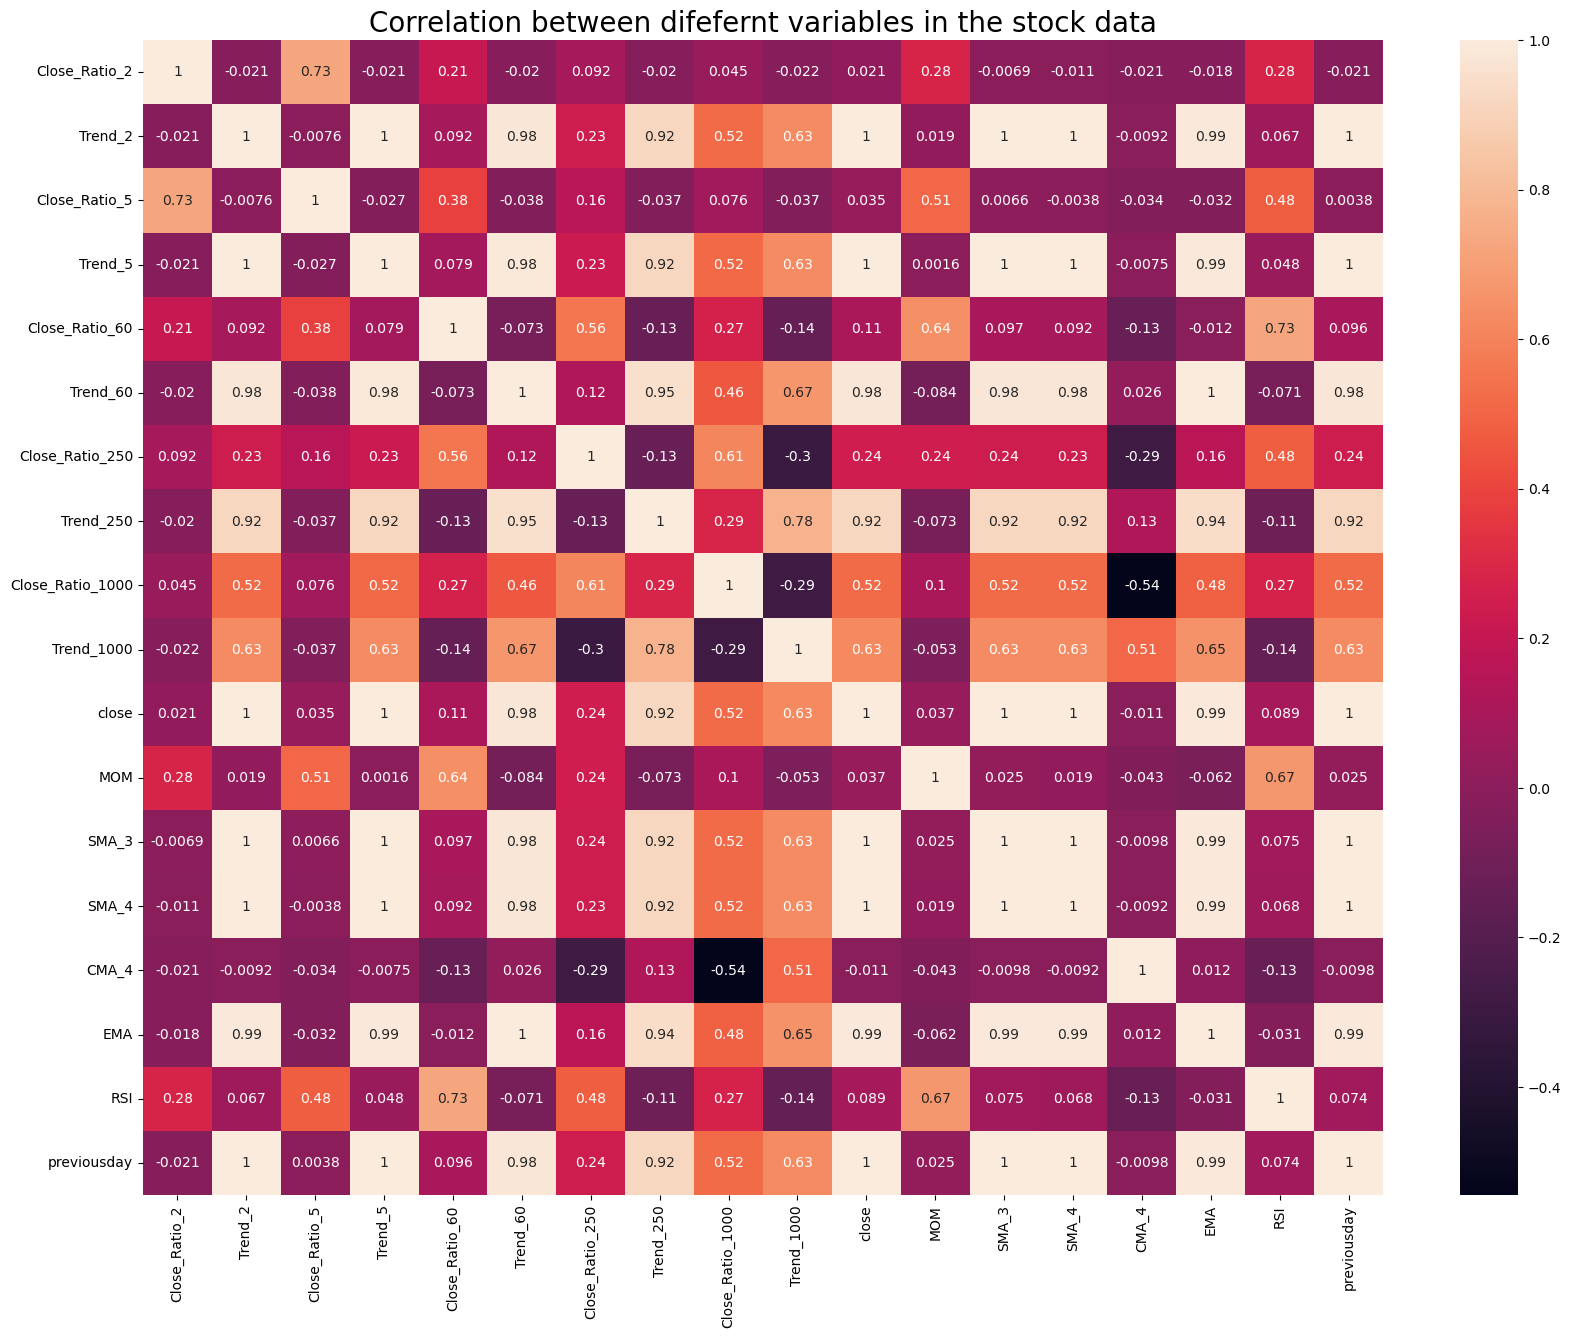

In [58]:
plt.figure(figsize=[20,15])
sns.heatmap(data=new_data.corr(), annot=True);
plt.title('Correlation between difefernt variables in the stock data', fontsize=20); 

In [43]:
train = new_data.iloc[:-1000]
test = new_data.iloc[-1000:]

In [44]:
train.shape

(5551, 18)

In [45]:
new_data.columns

Index(['Close_Ratio_2', 'Trend_2', 'Close_Ratio_5', 'Trend_5',
       'Close_Ratio_60', 'Trend_60', 'Close_Ratio_250', 'Trend_250',
       'Close_Ratio_1000', 'Trend_1000', 'close', 'MOM', 'SMA_3', 'SMA_4',
       'CMA_4', 'EMA', 'RSI', 'previousday'],
      dtype='object')

In [46]:
predictors= ['SMA_3','SMA_4','EMA','RSI','MOM', 'previousday'] 

#### Retrain the models on the new predictors

In [47]:
# creating a dictionary of Regressors to be experimented on.
models_dict = {
          'RF Regressor':RandomForestRegressor(random_state=0),
          'xgboost': XGBRegressor(),'Gradient Boost': GradientBoostingRegressor(random_state=0),
    'Catboostregressor':CatBoostRegressor(iterations=100, early_stopping_rounds=50)
         }

#looping through all the regressors, fitting and evaluating them on Cross validation and test data respectively
for key, model in models_dict.items():
    model.fit(train[predictors], train['close'])
    print(f'Performance of "{key}" on  Test set:')
    print('=='*28)
    print ( 'Test set:')
    print("**"*8)
    evaluate_model(model,test[predictors], test['close'])

Performance of "RF Regressor" on  Test set:
Test set:
****************
MAE: 0.34
MAPE: 0.01
minae: 0.00
maxae: 2.39
medae: 0.25

Performance of "xgboost" on  Test set:
Test set:
****************
MAE: 0.33
MAPE: 0.01
minae: 0.00
maxae: 1.76
medae: 0.26

Performance of "Gradient Boost" on  Test set:
Test set:
****************
MAE: 0.35
MAPE: 0.01
minae: 0.00
maxae: 2.16
medae: 0.27

Learning rate set to 0.348972
0:	learn: 8.5604360	total: 9.09ms	remaining: 900ms
1:	learn: 5.8295057	total: 14.4ms	remaining: 704ms
2:	learn: 3.9880763	total: 20.6ms	remaining: 666ms
3:	learn: 2.7396553	total: 28.6ms	remaining: 686ms
4:	learn: 1.9562724	total: 32.6ms	remaining: 619ms
5:	learn: 1.4629200	total: 44.7ms	remaining: 700ms
6:	learn: 1.1714352	total: 48.7ms	remaining: 647ms
7:	learn: 1.0144687	total: 58.1ms	remaining: 669ms
8:	learn: 0.9171996	total: 62.8ms	remaining: 635ms
9:	learn: 0.8616610	total: 71.6ms	remaining: 644ms
10:	learn: 0.8301722	total: 77.6ms	remaining: 628ms
11:	learn: 0.7862424	tot

#### Improving the model

In [48]:
#model_1 = RandomForestClassifier(n_estimators=200, min_samples_split=50, random_state=1)
#n_estimators=200, min_samples_split=50, random_state=1
model_2= GradientBoostingRegressor(random_state=0)

def predict(train, test, predictors_1, model_1):
    model_1.fit(train[predictors_1], train["Target"])
    preds_1 = model_1.predict_proba(test[predictors_1])[:,1]
    preds_1[preds_1 >=.6] = 1
    preds_1[preds_1 <.6] = 0
    preds_1 = pd.Series(preds_1, index=test.index, name="Predictions_1")
    combined_1 = pd.concat([test["Target"], preds_1], axis=1)
    return combined_1 

In [49]:
def predict(train, test, predictors, model_2):
    model_2.fit(train[predictors], train["close"])
    preds_2 = model_2.predict(test[predictors])
    preds_2 = pd.Series(preds_2, index=test.index, name="Predictions_2")
    combined_2 = pd.concat([test["close"], preds_2], axis=1)
    return combined_2

In [50]:
def backtest(new_data, model_2, predictors, start=1500, step=250):
    all_predictions = []

    for i in range(start, new_data.shape[0], step):
        train = new_data.iloc[0:i].copy()
        test = new_data.iloc[i:(i+step)].copy()
        predictions_2 = predict(train, test, predictors, model_2)
        all_predictions.append(predictions_2)
    
    return pd.concat(all_predictions)

In [51]:
predictions_2 = backtest(new_data, model_2, predictors)

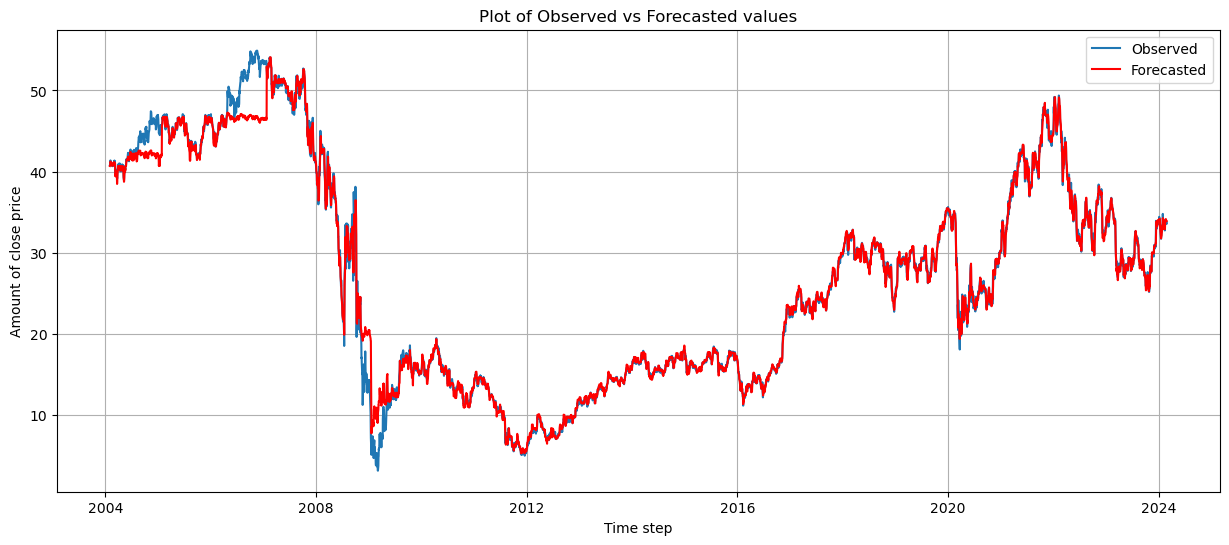

In [52]:
# Plot the test predictions and true values
plt.figure(figsize=(15,6))
plt.plot(predictions_2['close'], label='Observed')
plt.plot(predictions_2['Predictions_2'], color='r', label='Forecasted')
plt.title('Plot of Observed vs Forecasted values')
plt.ylabel('Amount of close price')
plt.xlabel('Time step')
plt.legend()
plt.grid()
plt.savefig('forcast.png')
plt.show()

In [53]:
model_2.fit(train[predictors], train['close'])
prediction=model.predict(test[predictors])

In [54]:
mape= mean_absolute_percentage_error(test['close'], prediction)
mae=mean_absolute_error(test['close'], prediction)

In [55]:
print('mean absolute percentage error is : {}\n'.format(mape))
print('mean absolute  error is : {}\n'.format(mae))

mean absolute percentage error is : 0.011794208342751744

mean absolute  error is : 0.38208859798951017



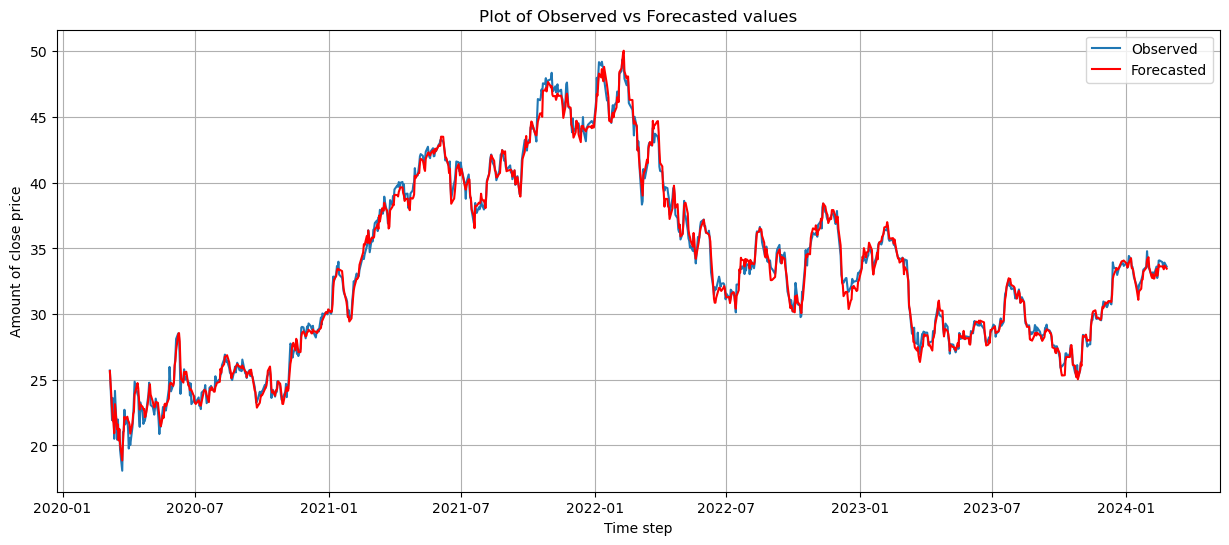

In [56]:
# Plot the test predictions and true values
pred= pd.Series(prediction, index=test.index)
plt.figure(figsize=(15,6))
plt.plot(test['close'], label='Observed')
plt.plot(pred, color='r', label='Forecasted')
plt.title('Plot of Observed vs Forecasted values')
plt.ylabel('Amount of close price')
plt.xlabel('Time step')
plt.legend()
plt.grid()
plt.savefig('forcast.png')
plt.show()

#### Perform Hyper parameter tuning using grid searchcv

#possibe hyperparameters for random forest
hyper = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 6]
}

from sklearn.model_selection import GridSearchCV

cv_model= GridSearchCV(GradientBoostingRegressor(), param_grid=hyper)
cv_model.fit(train[predictors], train['close'])

print(cv_model.best_score_)
print(cv_model.best_estimator_)

In [57]:
model = GradientBoostingRegressor(max_depth=5, n_estimators=100, learning_rate=0.1, min_samples_split=5)
model.fit(train[predictors], train['close'])
prediction=model.predict(test[predictors])

In [58]:
grdb_mae =  mean_absolute_error(test['close'], prediction)
abs_errors= np.abs(np.array(prediction) - np.array(test['close']))
grdb_min_abs_errors= np.min(abs_errors)
grdb_max_abs_errors= np.max(abs_errors)
grdb_med_abs_errors= np.median(abs_errors)
grdb_mape = mean_absolute_percentage_error(test['close'], prediction)

In [59]:
print(f"Optimized Gradient boosting Performance Metrics \n\n \
gradientboost Mae: {grdb_mae} \n \
gradientboost minae: {grdb_min_abs_errors} \n \
gradientboost maxae: {grdb_max_abs_errors} \n \
gradientboost medae: {grdb_med_abs_errors} \n \
gradientboost Mape: {grdb_mape} \n \
 \n\n <-------------------------------------------------->\n")

Optimized Gradient boosting Performance Metrics 

 gradientboost Mae: 0.3214946188746617 
 gradientboost minae: 3.392561912818337e-05 
 gradientboost maxae: 1.9798160670874907 
 gradientboost medae: 0.24792368855175262 
 gradientboost Mape: 0.010054900441241764 
  

 <-------------------------------------------------->



In [60]:
pred= pd.Series(prediction, index=test.index)
combined= pd.concat([test['close'], pred],axis=1)
combined 

,close,0
date,,
2020-03-06,25.709999,25.376826
2020-03-09,21.930000,22.811457
2020-03-10,23.610001,22.882258
2020-03-11,22.670000,21.650500
2020-03-12,20.510000,21.400736
...,...,...
2024-02-20,33.959999,34.056561
2024-02-21,33.700001,33.938801
2024-02-22,33.610001,33.566601


In [61]:
mape= mean_absolute_percentage_error(test['close'], prediction)
mae=mean_absolute_error(test['close'], prediction)

In [62]:
print('mean absolute percentage error is : {}\n'.format(mape))
print('mean absolute  error is : {}\n'.format(mae))

mean absolute percentage error is : 0.010054900441241764

mean absolute  error is : 0.3214946188746617



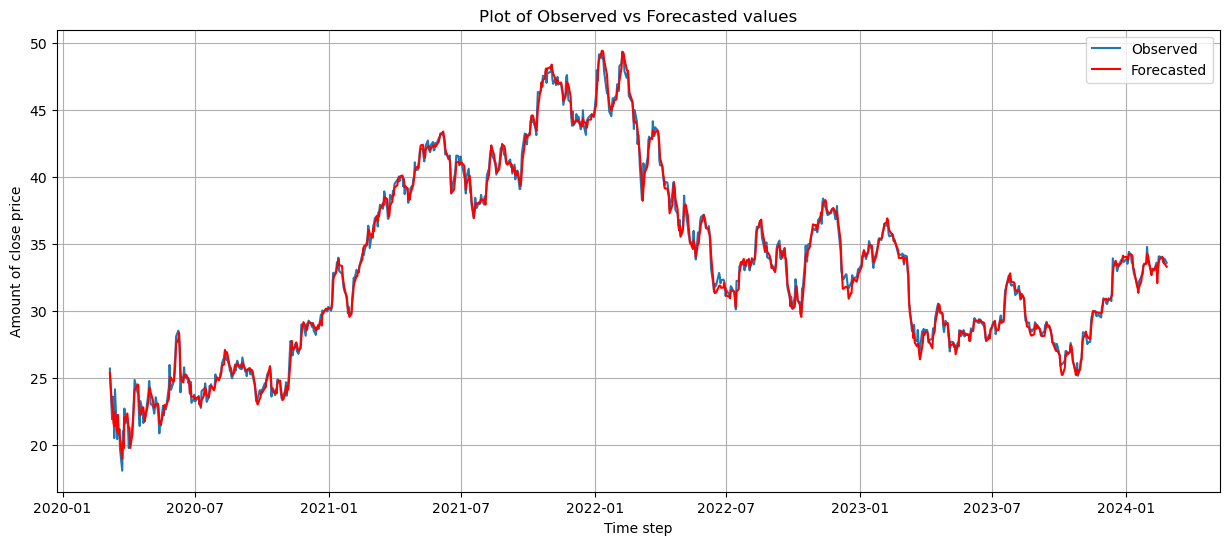

In [63]:
# Plot the test predictions and true values
plt.figure(figsize=(15,6))
plt.plot(combined['close'], label='Observed')
plt.plot(combined[0], color='r', label='Forecasted')
plt.title('Plot of Observed vs Forecasted values')
plt.ylabel('Amount of close price')
plt.xlabel('Time step')
plt.legend()
plt.grid()
plt.savefig('forcast.png')
plt.show()

### Stacking and Bagging

In [64]:
# List of machine learning algorithms to consider
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso,ElasticNet 
algorithms = [
    ('Linear regression', LinearRegression(), {}),
    ('Ridge', Ridge(), {}),
    ('Lasso', Lasso(), {}),
    ('Elastic Net', ElasticNet(), {}),
    #('SVM', SVC(kernel='linear', probability=True, decision_function_shape='ovr'), {}),
    ('MLP', MLPRegressor(), {})
]

# Train base models
base_models = {}
for algorithm_name, algorithm, _ in algorithms:
    print(algorithm)
    model = algorithm
    model.fit(train[predictors], train['close'])
    base_models[algorithm_name] = model

eval_metrics = ['mae', 'mape']
results = pd.DataFrame(columns=['Algorithm'] + eval_metrics)

for algorithm_name, model in base_models.items():
    y_pred = model.predict(test[predictors])
    mae= mean_absolute_error(test['close'], y_pred)
    mape =mean_absolute_percentage_error(test['close'], y_pred)

# Ensembling using Bagging with all base models
bagging_model = BaggingRegressor(base_estimator=None, n_estimators=10, random_state=42)
bagging_model.fit(train[predictors], train['close'])
bagging_y_pred = bagging_model.predict(test[predictors])
bagging_mae = mean_absolute_error(test['close'], bagging_y_pred)
abs_errors= np.abs(np.array(bagging_y_pred) - np.array(test['close']))
bagg_min_abs_errors= np.min(abs_errors)
bagg_max_abs_errors= np.max(abs_errors)
bagg_med_abs_errors= np.median(abs_errors)
bagging_mape = mean_absolute_percentage_error(test['close'], bagging_y_pred)
print(f"Bagging Ensemble Method Performance Metrics \n\n \
bagging Mae: {bagging_mae} \n \
bagging minae: {bagg_min_abs_errors} \n \
bagging maxae: {bagg_max_abs_errors} \n \
bagging medae: {bagg_med_abs_errors} \n \
bagging Mape: {bagging_mape} \n \
 \n\n <-------------------------------------------------->\n")

# Ensembling using Stacking
meta_model = Ridge()
stacking_model = StackingRegressor(estimators=list(base_models.items()), final_estimator=meta_model)
stacking_model.fit(train[predictors], train['close'])
stacking_y_pred = stacking_model.predict(test[predictors])
stacking_mae =  mean_absolute_error(test['close'], stacking_y_pred)
abs_errors= np.abs(np.array(stacking_y_pred) - np.array(test['close']))
stack_min_abs_errors= np.min(abs_errors)
stack_max_abs_errors= np.max(abs_errors)
stack_med_abs_errors= np.median(abs_errors)
stacking_mape = mean_absolute_percentage_error(test['close'], stacking_y_pred)
print(f"Stacking Ensemble Method Performance Metrics \n\n \
stacking mae: {stacking_mae} \n \
stacking minae: {stack_min_abs_errors} \n \
stacking maxae: {stack_max_abs_errors} \n \
stacking medae: {stack_med_abs_errors} \n \
stacking mape: {stacking_mape} \n")




#print(f"Stacking F1 Score: {stacking_f1}")


LinearRegression()
Ridge()
Lasso()
ElasticNet()
MLPRegressor()
Bagging Ensemble Method Performance Metrics 

 bagging Mae: 0.35895448599999996 
 bagging minae: 0.0003753000000017437 
 bagging maxae: 2.5778748 
 bagging medae: 0.264998450000002 
 bagging Mape: 0.011229194337409078 
  

 <-------------------------------------------------->

Stacking Ensemble Method Performance Metrics 

 stacking mae: 0.26864980860191723 
 stacking minae: 4.0400217883984624e-05 
 stacking maxae: 1.6906935790960915 
 stacking medae: 0.2040386971291781 
 stacking mape: 0.008467928784392995 



In [65]:
bagging_y_pred= pd.Series(bagging_y_pred, index=test.index)
stacking_y_pred= pd.Series(stacking_y_pred, index=test.index)

In [66]:
combined_stack= pd.concat([test['close'], stacking_y_pred],axis=1)
combined_bagg= pd.concat([test['close'], bagging_y_pred], axis=1)

In [67]:
combined_bagg.head()

,close,0
date,,
2020-03-06,25.709999,26.606750
2020-03-09,21.930000,24.355875
2020-03-10,23.610001,23.985750
2020-03-11,22.670000,22.041000
2020-03-12,20.510000,21.692500


In [68]:
combined_stack

,close,0
date,,
2020-03-06,25.709999,26.470599
2020-03-09,21.930000,22.829732
2020-03-10,23.610001,23.831681
2020-03-11,22.670000,21.327796
2020-03-12,20.510000,21.857500
...,...,...
2024-02-20,33.959999,34.230606
2024-02-21,33.700001,33.797729
2024-02-22,33.610001,33.669552


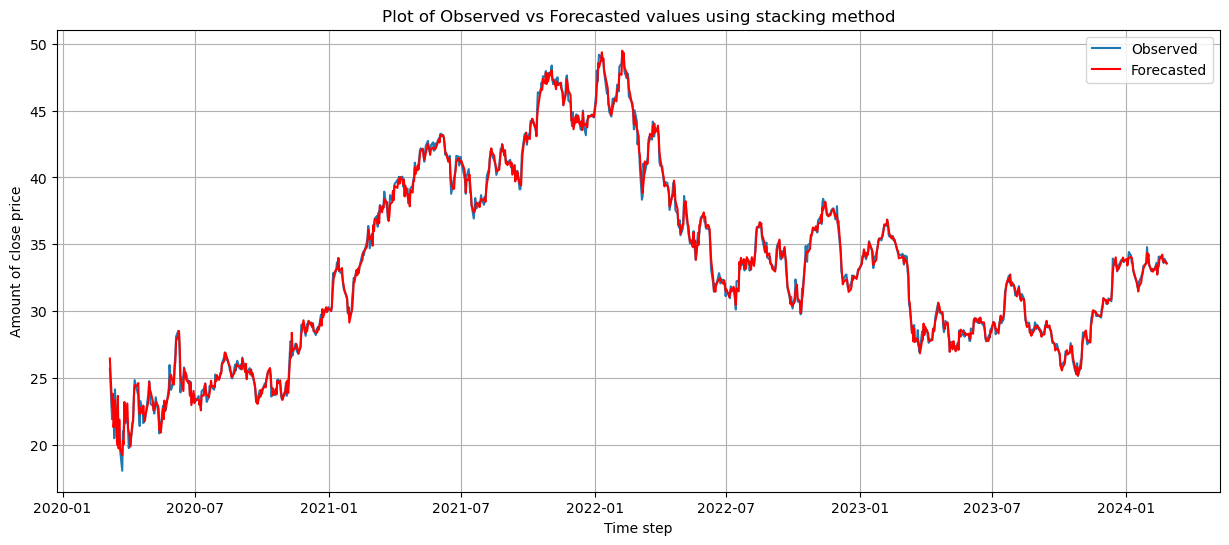

In [69]:
# Plot the test predictions and true values
plt.figure(figsize=(15,6))
plt.plot(combined_stack['close'], label='Observed')
plt.plot(combined_stack[0], color='r', label='Forecasted')
plt.title('Plot of Observed vs Forecasted values using stacking method')
plt.ylabel('Amount of close price')
plt.xlabel('Time step')
plt.legend()
plt.grid()
plt.savefig('forcast.png')
plt.show()

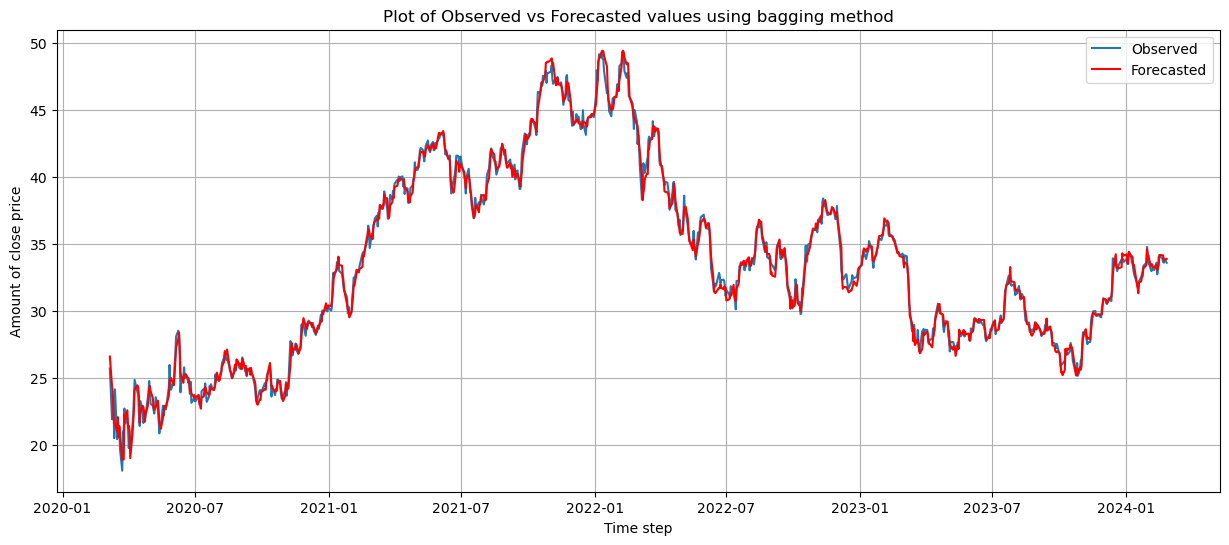

In [70]:
# Plot the test predictions and true values
plt.figure(figsize=(15,6))
plt.plot(combined_bagg['close'], label='Observed')
plt.plot(combined_bagg[0], color='r', label='Forecasted')
plt.title('Plot of Observed vs Forecasted values using bagging method')
plt.ylabel('Amount of close price')
plt.xlabel('Time step')
plt.legend()
plt.grid()
plt.savefig('forcast.png')
plt.show()

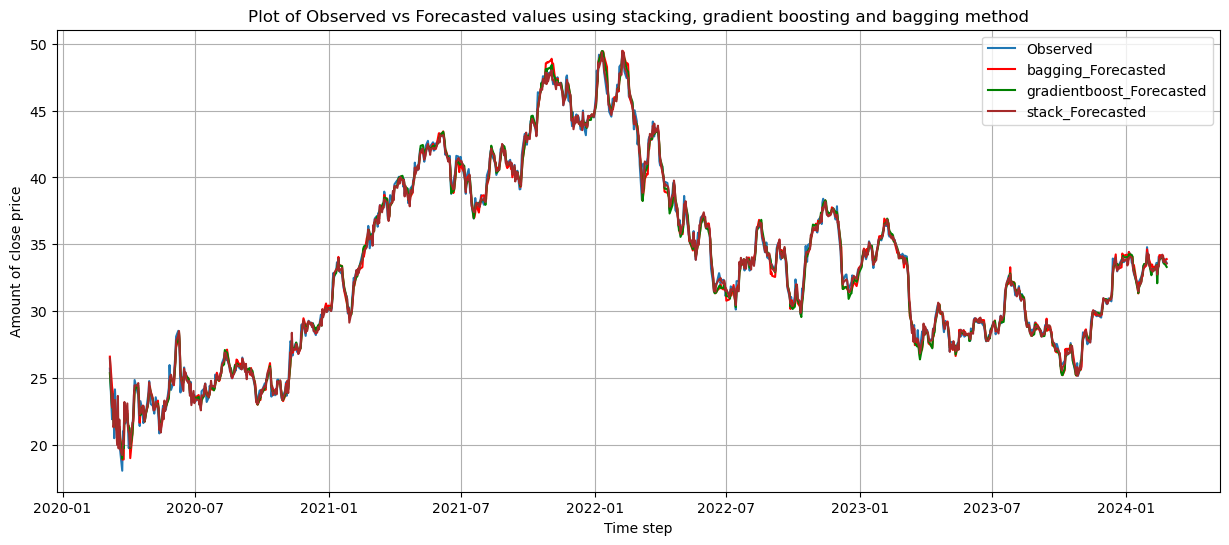

In [71]:
# Plot the test predictions and true values
plt.figure(figsize=(15,6))
plt.plot(combined_bagg['close'], label='Observed')
plt.plot(combined_bagg[0], color='r', label='bagging_Forecasted')
plt.plot(combined[0], color='green', label='gradientboost_Forecasted')
plt.plot(combined_stack[0], color='brown', label='stack_Forecasted')
plt.title('Plot of Observed vs Forecasted values using stacking, gradient boosting and bagging method')
plt.ylabel('Amount of close price')
plt.xlabel('Time step')
plt.legend()
plt.grid()
plt.savefig('Bankofamericaresult.png')
plt.show()

In [72]:
from prettytable import PrettyTable
import joblib
import os
# Constructing the result summary table containing the scores for each model on  test dataset.

task1_result = PrettyTable()
task1_result.field_names = ["Regressor", "MAE on Test","MAPE on Test", "MinAE on Test", "MaxAE on Test", "MedAE on Test"]
task1_result.add_row(['RF Reg', 0.34, 0.01, 0.00, 2.39, 0.25])
task1_result.add_row(['XGboost', 0.33, 0.01, 0.00, 1.76, 0.26])
task1_result.add_row(['GradientBoost', 0.35, 0.01, 0.00, 2.16, 0.27])
task1_result.add_row(['Catboost', 0.38, 0.01, 0.00, 2.19, 0.30])
task1_result.add_row(['Bagging', 0.36, 0.01, 0.00, 2.58, 0.26])
task1_result.add_row(['Stacking', 0.27, 0.01, 0.00, 1.70, 0.20])

print('Result Summary for All Regressors :')
print(task1_result)

Result Summary for All Regressors :
+---------------+-------------+--------------+---------------+---------------+---------------+
|   Regressor   | MAE on Test | MAPE on Test | MinAE on Test | MaxAE on Test | MedAE on Test |
+---------------+-------------+--------------+---------------+---------------+---------------+
|     RF Reg    |     0.34    |     0.01     |      0.0      |      2.39     |      0.25     |
|    XGboost    |     0.33    |     0.01     |      0.0      |      1.76     |      0.26     |
| GradientBoost |     0.35    |     0.01     |      0.0      |      2.16     |      0.27     |
|    Catboost   |     0.38    |     0.01     |      0.0      |      2.19     |      0.3      |
|    Bagging    |     0.36    |     0.01     |      0.0      |      2.58     |      0.26     |
|    Stacking   |     0.27    |     0.01     |      0.0      |      1.7      |      0.2      |
+---------------+-------------+--------------+---------------+---------------+---------------+
